In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# Save/Load as mat.
from scipy.io import savemat, loadmat
import h5py
import mat73 # https://github.com/skjerns/mat7.3

# Progress Bar
from rich.progress import track
from rich.progress import Progress

# Other
import argparse
import multiprocessing as mp
import os
import scipy.signal as signal
import time

# User-defined
from mat2np_segment_all_subject import *
from dsp_preprocess import *
from dataset_parser import *
from models import *
from feature_extractor import *
from set_args import *
from train_test_process import *

In [2]:
config = {
        "F": 5,
        "Pt": 1,
        "Pf": 5,
        "Qf": 10,
        "dim": 144,
        "depth": 1,
        "heads": 8,
        "mlp_dim": 720,
        "dropout": 0.2,
        "emb_dropout": 0.2
	}

(100000,)
(2049,)
(27,)
(2049, 27)


Text(0.5, 0, 'Time [sec]')

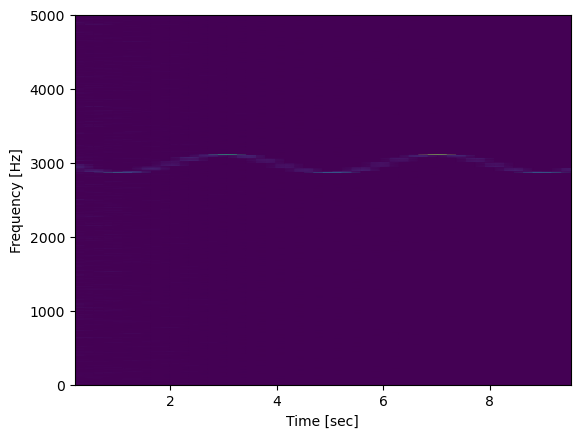

In [16]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

print(x.shape)

f, t, Sxx = signal.spectrogram(x, fs, nperseg = 4096)

print(f.shape)
print(t.shape)
print(Sxx.shape)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')


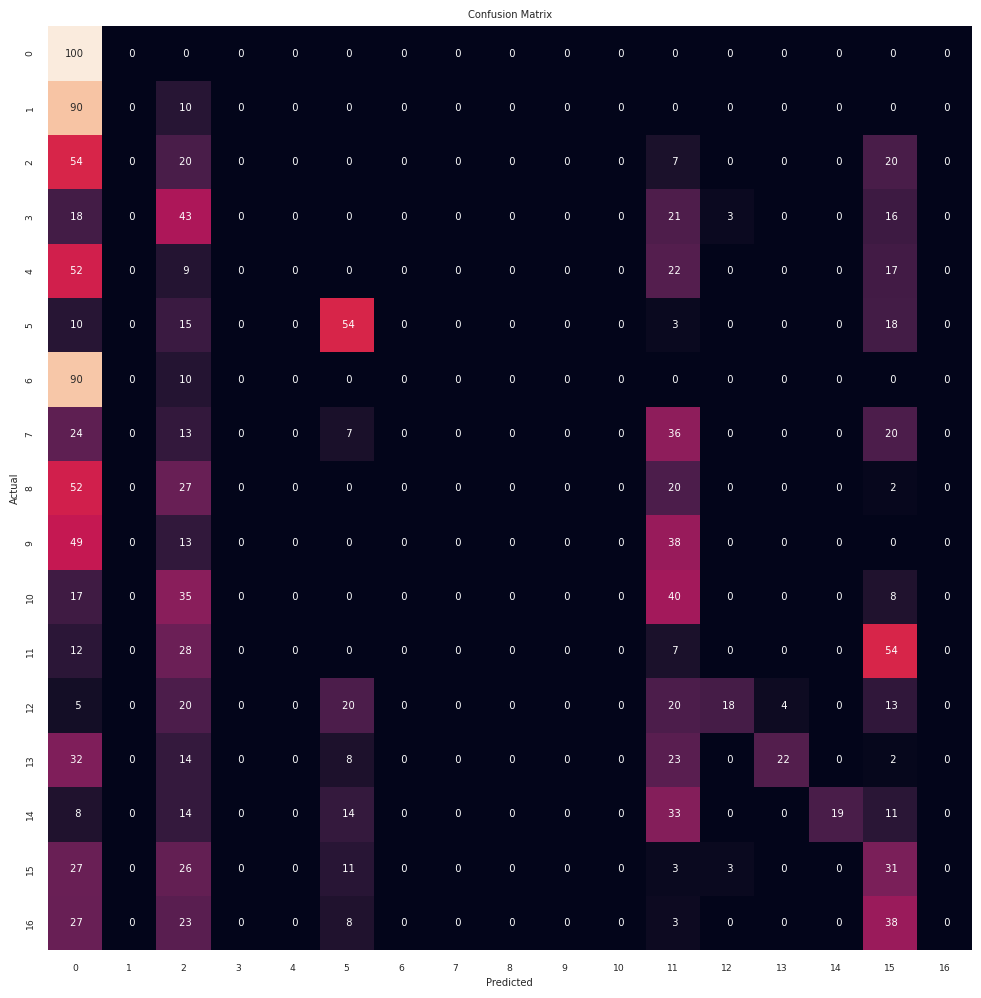

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

def plot_cm(y_gold, y_pred, log_name=None):

    # Calculate the confusion matrix
    cm = confusion_matrix(y_gold, y_pred, normalize='true')*100

    # Plot the confusion matrix using seaborn and matplotlib
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=0.6)
    sns.heatmap(cm, annot=True, fmt="3.0f", cbar=False, square=True, xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    if log_name is not None:
        # Save as npy and png
        PATH = f"Results/{log_name}"
        if not os.path.isdir(PATH):
            os.mkdir(PATH)

        plt.savefig(f"{PATH}/confusion_matrix.svg")
        plt.savefig(f"{PATH}/confusion_matrix.png", dpi=300)
        np.save(f"{PATH}/y_pred.npy", y_pred)
        np.save(f"{PATH}/y_gold.npy", y_gold)

y_gold = np.load("Results/20231110_0059_main_develop_DB2/y_gold.npy")
y_pred = np.load("Results/20231110_0059_main_develop_DB2/y_pred.npy")

# print(y_gold[50:100])
# print(y_pred[50:100])

(y_gold == y_pred).mean()
plot_cm(y_gold,y_pred,"test")

In [17]:
def dataset_filter_normalize_segementation_all_subject_exercise(dataset_type="train", subject_list = [i+1 for i in range(40)], \
                                                                exercise_list = [1,2,3], fs=2000, window_size = 400, window_step=200, num_channel=12, class_rest=False, \
                                                                    type_filter = "BPF_20_200", type_norm = "mvc"):
    if dataset_type == "test":
        trial_list = [2,5]
    else: 
        trial_list = [1,3,4,6]
    
    # Preallocate memory for speed up
    num_sample_max = int(1e6)
    emg_sample_dataset = np.zeros((num_sample_max, window_size, num_channel))
    gesture_label_dataset = np.zeros((num_sample_max))
    cnt = 0
    # print('', end='', flush=True)
    for i, idx_subject in enumerate(subject_list):
        # start = time.time()
        end_tpye = '\n' if i==len(subject_list)-1 else '\r'
        # end_tpye = '\n'
        print("Loading %2d-th subject for %s dataset ..." %(idx_subject, dataset_type), end=end_tpye, flush=True)
        for idx_exercise in exercise_list:
            for idx_quarter, idx_trial in enumerate(trial_list):
                PATH_seg_np = "Dataset/DB2/DB2_np/DB2_s_{}/exercise_{}/trial_{}/".format(idx_subject,idx_exercise,idx_trial)
                fileNames = [PATH_seg_np+i for i in os.listdir(PATH_seg_np)]
                for fileName in fileNames:
                    print(fileName)
                    
                    [emg_sample_filter_norm_seg_batch, gesture_label_batch] = dataset_filter_normalize_segementation(\
                        fileName, fs=fs, window_size=window_size, window_step=window_step, num_channel=num_channel,type_filter = type_filter, type_norm = type_norm)
                    
                    num_window = gesture_label_batch.shape[0]
                    num_channel = emg_sample_filter_norm_seg_batch.shape[2]

                    if dataset_type != "test":
                        num_window_valid = np.floor(num_window/4).astype(int)   # one certain quarter for validation
                        idx_all = range(num_window)
                        idx_valid = range(idx_quarter*num_window_valid,(idx_quarter+1)*num_window_valid)
                        idx_train = [i for i in idx_all if i not in idx_valid]
                        if dataset_type == "train":
                            idx_datatype = idx_train
                        elif dataset_type == "valid":
                            idx_datatype = idx_valid

                        emg_sample_filter_norm_seg_batch = emg_sample_filter_norm_seg_batch[idx_datatype]
                        gesture_label_batch = gesture_label_batch[idx_datatype]

                    num_sample = emg_sample_filter_norm_seg_batch.shape[0]
                    emg_sample_dataset[cnt:cnt+num_sample] = emg_sample_filter_norm_seg_batch

                    if exercise_list == [2]:
                        gesture_label_batch = gesture_label_batch-17
                    elif exercise_list == [3]:
                        gesture_label_batch = gesture_label_batch -17 -23
                    gesture_label_dataset[cnt:cnt+num_sample] = np.squeeze(gesture_label_batch-1+int(class_rest)) # Counting the label from 0 if "rest" class is not considered

                    cnt += num_sample   # counter to indicate the size of current dataset

                    print(np.abs(emg_sample_filter_norm_seg_batch).mean())

        # end = time.time()
        # print("Elasped time: ", end - start)
    
    emg_sample_dataset = emg_sample_dataset[0:cnt]
    gesture_label_dataset = gesture_label_dataset[0:cnt]
    
    # return emg_sample_dataset, gesture_label_dataset

In [18]:
dataset_filter_normalize_segementation_all_subject_exercise(dataset_type="test", subject_list = [1,2])

Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_9.npy
0.00896178801896394
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_3.npy
0.012161494310723813
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_7.npy
0.0035148052680888404
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_14.npy
0.014804474087966143
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_4.npy
0.013926235422967658
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_16.npy
0.011399656544515403
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_17.npy
0.012839852335396524
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_11.npy
0.011211615771223716
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_15.npy
0.02153474594482591
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_5.npy
0.009988708303265538
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_2.npy
0.00635480283056434
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_13.npy
0.01679343686911733
Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_2/G_8.npy
0.014973004517242925
Dataset/DB2/DB2_np/DB2

In [2]:
# Model Testing
# Dataset setup
train_loader, valid_loader, test_loader = train_test_split_DataLoader(batch_size = 256, subject_list = [i+1 for i in range(40)], exercise_list=[1,2,3], fs=2000, \
                                window_size = 400, window_step=200, num_channel=12, feat_extract = True, class_rest = False)


----------------------------------------------------------------------
Loading saved train dataset in ./Dataset/DB2/
Loading saved valid dataset in ./Dataset/DB2/
Loading saved test dataset in ./Dataset/DB2/
----------------------------------------------------------------------
Number of train data: 254869
Number of valid data: 81360
Number of test  data: 167941
----------------------------------------------------------------------



In [3]:
def test_process(model,model_PATH,test_loader,device,criterion,load_model,model_type):
    if load_model == True:
        print("model_PATH: ",model_PATH)
        model.load_state_dict(torch.load(model_PATH))
        

    with Progress() as progress:
        # Testing Stage
        model.eval() # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        # task4 = progress.add_task("[blue]Batch ", total=len(test_loader))
        running_loss_test = 0.0
        running_acc_test = 0.0
        n_test = 0

        y_pred = []
        y_gold = []

        with torch.no_grad():
            for i, (emg_sample, gesture_gold) in enumerate(test_loader):
                emg_sample = emg_sample.to(device) # input
                gesture_gold = gesture_gold.to(device) # Output

                if model_type == "ViT":
                    # emg_sample = torch.unsqueeze(emg_sample.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
                    emg_sample = emg_sample.permute(0,2,1)  # shape: (B, C, 1*W*F)
                gesture_pred = model(emg_sample)

                y_pred.extend(gesture_pred.argmax(dim=-1).view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
                y_gold.extend(gesture_gold.view(-1).detach().cpu().numpy())      # target是ground-truth的labe
                
                loss = criterion(gesture_pred,gesture_gold)

                running_loss_test += loss.detach().item()*emg_sample.shape[0]
                num_correct = (torch.argmax(gesture_pred, dim=1)==gesture_gold).sum()
                running_acc_test += num_correct
                n_test += emg_sample.shape[0]

                # progress.update(task4, advance=1,description="[blue][Test loss: %3.3f] [Test acc: %3.2f %%]: " % (running_loss_test/n_test, 100*running_acc_test/n_test))
            print("[Test loss: %3.3f] [Test acc: %3.2f %%] " % (running_loss_test/n_test, 100*running_acc_test/n_test), flush=True)

    # Print the model summary
    summary(model, (emg_sample.shape[1:]))

    return y_pred, y_gold



In [4]:
from vit import *

device = "cuda:1" if torch.cuda.is_available() else "cpu"

num_patch = 12
patch_size = 400
# model = ViT(num_patch,patch_size).to(device)
model = DNN_feature().to(device)
model_type = "DNN_feature"
model_PATH = f'./Models/{model_type}_model.pth'

criterion = nn.CrossEntropyLoss()
y_pred, y_gold = test_process(model,model_PATH,test_loader,device,criterion,load_model=True,model_type=model_type)

model_PATH:  ./Models/DNN_feature_model.pth


Output()

[Test loss: 2.395] [Test acc: 31.71 %]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 49]                  --
|    └─Linear: 2-1                       [-1, 128]                 7,680
|    └─LeakyReLU: 2-2                    [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─LeakyReLU: 2-4                    [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 49]                  3,185
Total params: 19,121
Trainable params: 19,121
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.08


Text(0.5, 1.0, 'Confusion Matrix')

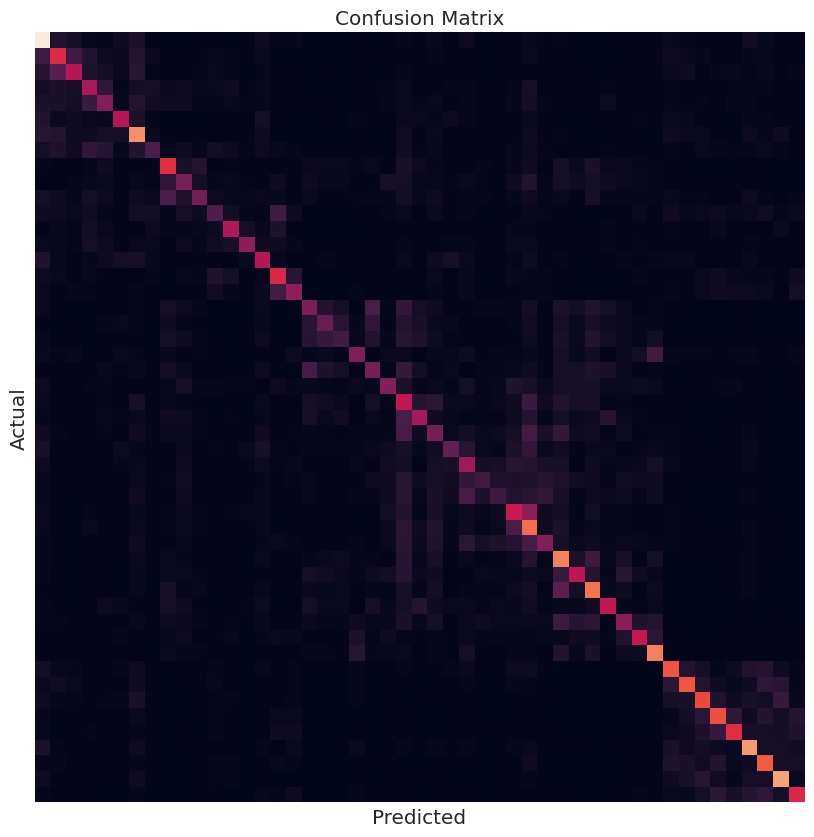

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_pred and y_gold are your prediction and ground truth lists
# Convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_gold = np.array(y_gold)

# Calculate the confusion matrix
cm = confusion_matrix(y_gold, y_pred)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=False, fmt='d', cbar=False, square=True, xticklabels=False, yticklabels=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [ ]:

# emg_sample_filter = filter(emg_sample,type_filter="HPF")
# x_filter = emg_sample_filter[:,0]
# x = emg_sample[:,0]
# # emg_sample_norm = normalization(emg_sample, type_norm="max_min")

# plt.figure(figsize=(12, 4))
# plt.plot(x)   # red line without marker
# plt.plot(x_filter)   # red line without marker
# plt.show()

# x_concat = np.concatenate((x.reshape(-1,1),x_filter.reshape(-1,1)),axis=1)
# plot_FFT(x_concat, fs)

# ## After filter and normalization
# emg_sample_filter_norm = normalization(emg_sample_filter, type_norm="standardization")
# plt.figure(figsize=(12, 4))
# plt.plot(emg_sample_filter_norm[:,0])   # red line without marker
# plt.show()

# plot_FFT(emg_sample_filter_norm[:,0].reshape(-1,1), fs)

## ViT

In [6]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        print("Z: ", x.shape)
        qkv = self.to_qkv(x).chunk(3, dim = -1) # q, k, v's shape: (num_batch, num_patch+1, dim)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv) # q, k, v's shape: (num_batch, head, num_patch+1, dim/head)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale    # shape: (num_batch, head, num_patch+1, num_patch+1)

        attn = self.attend(dots) # shape: (num_batch, head, num_patch+1, num_patch+1)
        attn = self.dropout(attn) # shape: (num_batch, head, num_patch+1, num_patch+1)
        print("attn: ", attn.shape)

        out = torch.matmul(attn, v) # shape: (num_batch, head, num_patch+1, dim_head)
        out = rearrange(out, 'b h n d -> b n (h d)') # shape: (num_batch, num_patch+1, head*dim_head)

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    # def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
    def __init__(self, num_patch, patch_size, dim=32, depth=1, heads=4, mlp_dim = 128, dropout = 0., emb_dropout = 0., pool = 'cls', number_gesture=49, class_rest=False):
        super().__init__()
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        output_class = number_gesture + int(class_rest==True)
        print("num_patch: ", num_patch)
        print("patch_size: ", patch_size)

        self.to_patch_embedding = nn.Linear(patch_size, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patch + 1, dim))

        self.dropout = nn.Dropout(emb_dropout)

        dim_head = int(dim/heads)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, output_class)

    def forward(self, x):
        
        x = self.to_patch_embedding(x)
        batch_size, num_patch, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = batch_size)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x) # shape: (num_batch, num_patch+1, dim)
        print("test: ",x.shape)
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0] # shape: (num_batch, dim)

        x = self.to_latent(x)
        return self.mlp_head(x)

In [7]:
# emg_sample_dataset, gesture_label_dataset = \
#     dataset_filter_normalize_segementation_all_subject_exercise(dataset_type="train",subject_list=[1])

# batch_size = 128
# x = emg_sample_dataset[0:batch_size]
# x = torch.tensor(x, dtype=torch.float)
# x = torch.unsqueeze(x.permute(0,2,1), dim=3)  # shape: (B, C, W, F) = (128, 12, 400, 1)
# B, C, W, F = x.shape

# print("B, C, W, F = ", x.shape)

# # TNet
# num_patch = C
# patch_size = W
# xp = x.reshape(B,C,-1)

# vit = ViT(num_patch,patch_size)
# tmp = vit(xp)
# # print(tmp.shape)

## Butterworth filter

Loading  1-th subject for train dataset ...


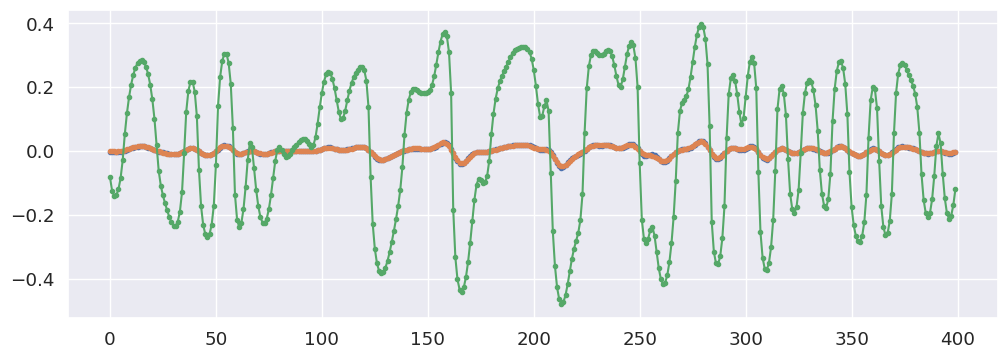

In [8]:
# ===================== Filter =====================
def butter_filter(x, type_filter="highpass", cut_low=20, cut_high = 500, fs=2000, order=4):
    nyq = 0.5 * fs
    if type_filter=="bandpass":
        normal_cut_low = [cut_low / nyq, cut_high / nyq]
    else:
        normal_cut_low = cut_low / nyq

    sos = signal.butter(N=order, Wn=normal_cut_low, btype=type_filter, output='sos')
    # y = signal.sosfilt(sos, x)
    y = signal.sosfiltfilt(sos,x,axis=1)
    return y

def filter(x, type_filter="none", cut_low=10, cut_high = 500, fs=2000, order=4):
    if type_filter == "none":
        y = x
    elif type_filter == "HPF":
        y = butter_filter(x, type_filter="highpass", cut_low=cut_low, fs=fs, order=order)
    elif type_filter == "LPF":
        y = butter_filter(x, type_filter="lowpass", cut_low=cut_low, fs=fs, order=order)
    elif type_filter == "BPF":
        y = butter_filter(x, type_filter="bandpass", cut_low=cut_low, cut_high=cut_high, fs=fs, order=order)
    else:
        raise TypeError(f'{type_filter} is not defined in type_filter')
    return y

# def filter_batch(x, type_filter="none", cut_low=10, cut_high = 500, fs=2000, order=3):
#     num_batch, window_size, num_channel = x.shape
#     y = np.zeros((num_batch, window_size, num_channel))
#     for i in range(num_batch):
#         for j in range(num_channel):
#             y[i,:,j] = filter(x[i,:,j], type_filter=type_filter, cut_low=cut_low, cut_high=cut_high,fs=fs,order=order)
            
#     return y

emg_sample_dataset, gesture_label_dataset = \
    dataset_filter_normalize_segementation_all_subject_exercise(dataset_type="train",subject_list=[1])

# print(emg_sample_dataset.shape)
emg_sample_dataset_filter = filter(emg_sample_dataset, "BPF", cut_low=20, cut_high = 200, order=3)
emg_sample_dataset_norm = normalization(emg_sample_dataset, type_norm="mu_law",mu=256)
plt.figure(figsize=(12, 4))
plt.plot(emg_sample_dataset[0,:,0], '.-')
plt.plot(emg_sample_dataset_filter[0,:,0], '.-')
plt.plot(emg_sample_dataset_norm[0,:,0], '.-')

## Feature extraction

In [9]:
# def feat_mav(x):    # mean absolute value
#     num_batch, window_size, num_channel = x.shape
#     y = np.mean(np.abs(x),axis=1)
#     y = y.reshape(num_batch,1,num_channel)
#     return y # shape: (num_batch, 1, num_channel)

# def feat_mavs(x):   # Mean Absolute Value Slope
#     num_batch, window_size, num_channel = x.shape
#     x_mav = feat_mav(x) # shape: (num_batch, 1, num_channel)
#     print(x_mav.shape)
#     y = x_mav[:,:,1:] - x_mav[:,:,:-1]
#     return y # shape: (num_batch, 1, num_channel-1)

# def feat_zc(x, th=5e-4):     # number of zero crossings
#     num_batch, window_size, num_channel = x.shape
#     # Assuming num_feature is 1 as we are only calculating zero crossings
#     y = np.zeros((num_batch, 1, num_channel))
    
#     for i in range(num_batch):
#         for j in range(num_channel):
#             # Get the current window
#             window = x[i, :, j] # shape: (window_size,)
#             window_leftshift = np.concatenate((window[1:],window[-1].reshape(1)))
#             isLargerTH = np.abs(window - window_leftshift) >= th

#             window_sign = np.sign(window)   # shape: (window_size,)
#             window_sign_rightshift = np.concatenate((window_sign[0].reshape(1),window_sign[0:-1]))

#             isCross = (window_sign*window_sign_rightshift==-1)
            
#             crossings = (isCross & isLargerTH).sum()

#             y[i, 0, j] = crossings
    
#     return y # shape: (num_batch, 1, num_channel)

# def feat_ssc(x, th=5e-4):   # Slope Sign Changes
#     num_batch, window_size, num_channel = x.shape
#     # Assuming num_feature is 1 as we are only calculating zero crossings
#     y = np.zeros((num_batch, 1, num_channel))

#     for i in range(num_batch):
#         for j in range(num_channel):
#             # Get the current window
#             window_1 = x[i, 0:-2, j] # shape: (window_size-2,)
#             window_2 = x[i, 1:-1, j] # shape: (window_size-2,)
#             window_3 = x[i, 2:  , j] # shape: (window_size-2,)

#             isLargerTH1 = np.abs(window_2 - window_1) >= th
#             isLargerTH2 = np.abs(window_2 - window_3) >= th
#             isLargeTH = isLargerTH1 | isLargerTH2

#             isMaximal = (window_2 > window_1) & (window_2 > window_3)
#             isMinimal = (window_2 < window_1) & (window_2 < window_3)
#             isLocal = isMaximal | isMinimal

#             y[i, 0, j] = (isLocal & isLargeTH).sum()

#     return y # shape: (num_batch, 1, num_channel)

# def feat_wl(x):    # Waveform Length
#     num_batch, window_size, num_channel = x.shape
#     y = np.sum(np.abs(x[:,1:,:] - x[:,:-1,:]),axis=1)
#     y = y.reshape(num_batch,1,num_channel)
#     return y # shape: (num_batch, 1, num_channel)

# x = np.expand_dims(emg_sample_dataset[0], axis=0)
# x = emg_sample_dataset[0:]
# # y = feat_mavs(x)
# # print(y)
# # plt.figure(figsize=(16,4))
# # plt.plot(x[0,:,0], '-o')
# # plt.axhline(y=y[0,0,0], color = 'r', linestyle = '-') 

# # y = feat_zc(x, th=0.001)
# # print(y[0,0,0])
# # plt.figure(figsize=(16,4))
# # plt.plot(x[0,:,0], '-o')
# # plt.axhline(y = 0., color = 'r', linestyle = '-') 

# # y = feat_ssc(x, th=0.001)
# # print(y[0,0,0])
# # plt.figure(figsize=(16,4))
# # plt.plot(x[0,:,0], '-o')
# # # plt.plot(index[0,:,0], 'o')

# # y = feat_wl(x)
# # print(y[4200,0,0])
